In [1]:
# Istall libraries
!pip install geopandas
!pip install contextily

# Importing and installing the libraries
import numpy as np
import pandas as pd
import geopandas as gpd
import contextily as cx
import datetime
import matplotlib.pyplot as plt
import matplotlib.style as style

# Plot styles
style.use('fivethirtyeight')
plt.rcParams['axes.grid'] = False

     |████████████████████████████████| 1.0 MB 5.1 MB/s 
     |████████████████████████████████| 6.3 MB 44.5 MB/s 
     |████████████████████████████████| 16.7 MB 356 kB/s 
     |████████████████████████████████| 19.3 MB 10.0 MB/s 


In [2]:
# Loading all data

RAW_PATH = 'https://raw.githubusercontent.com/tamagusko/cycling-sustainable-mobility/main/data/raw/'
Air_pollution = RAW_PATH + 'Air_pollution.csv'
TF_ACCIDENTS_2019 = RAW_PATH + 'TF_ACCIDENTS_2019.xlsx'
TF_ACCIDENTS_2020 = RAW_PATH + 'TF_ACCIDENTS_2020.xlsx'
TF_ACCIDENTS_VICTIMS_2019 = RAW_PATH + 'TF_ACCIDENTS_VICTIMS_2019.xlsx'
TF_ACCIDENTS_VICTIMS_2020 = RAW_PATH + 'TF_ACCIDENTS_VICTIMS_2020.xlsx'
brussels_traversals_Uber_data = RAW_PATH + 'brussels-traversals_Uber_data.csv'
osm_data = RAW_PATH + 'osm_data.xlsx'
stations_villo = RAW_PATH + 'stations_villo.json'

# We chose to focus on 2020 data
AIR_POLLUTION = pd.read_csv(Air_pollution, sep=';')
# split into two lat and long
AIR_POLLUTION[['lat', 'long']] = AIR_POLLUTION['Coordinates'].str.split(',', expand=True) 
# TF_ACCIDENTS_2019 = pd.read_excel(TF_ACCIDENTS_2019)
TF_ACCIDENTS_2020 = pd.read_excel(TF_ACCIDENTS_2020)
# TF_ACCIDENTS_VICTIMS_2019 = pd.read_excel(TF_ACCIDENTS_VICTIMS_2019)
TF_ACCIDENTS_VICTIMS_2020 = pd.read_excel(TF_ACCIDENTS_VICTIMS_2020)
BRUSSEL_TRANSVERSALS_UBER = pd.read_csv(brussels_traversals_Uber_data)
STATIONS = pd.read_json(stations_villo)
# split into two lat and long
STATIONS = STATIONS.join(pd.json_normalize(STATIONS['position']))

In [3]:
TF_ACCIDENTS_VICTIMS_2020.shape

(66130, 43)

In [4]:
TF_ACCIDENTS_VICTIMS_2020.columns

Index(['DT_DAY', 'DT_HOUR', 'CD_DAY_OF_WEEK', 'TX_DAY_OF_WEEK_DESCR_FR',
       'TX_DAY_OF_WEEK_DESCR_NL', 'MS_VICT', 'MS_VIC_OK', 'MS_SLY_INJ',
       'MS_SERLY_INJ', 'MS_DEAD_30_DAYS', 'CD_BUILD_UP_AREA',
       'TX_BUILD_UP_AREA_DESCR_NL', 'TX_BUILD_UP_AREA_DESCR_FR',
       'CD_VICT_TYPE', 'TX_VICT_TYPE_DESCR_FR', 'TX_VICT_TYPE_DESCR_NL',
       'CD_ROAD_USER_TYPE', 'TX_ROAD_USR_TYPE_DESCR_FR',
       'TX_ROAD_USR_TYPE_DESCR_NL', 'CD_ROAD_TYPE', 'TX_ROAD_TYPE_DESCR_FR',
       'TX_ROAD_TYPE_DESCR_NL', 'CD_LIGHT_COND', 'TX_LIGHT_COND_DESCR_FR',
       'TX_LIGHT_COND_DESCR_NL', 'CD_AGE_CLS', 'TX_AGE_CLS_DESCR_FR',
       'TX_AGE_CLS_DESCR_NL', 'CD_MUNTY_REFNIS', 'TX_MUNTY_DESCR_FR',
       'TX_MUNTY_DESCR_NL', 'CD_DSTR_REFNIS', 'TX_ADM_DSTR_DESCR_FR',
       'TX_ADM_DSTR_DESCR_NL', 'CD_PROV_REFNIS', 'TX_PROV_DESCR_FR',
       'TX_PROV_DESCR_NL', 'CD_RGN_REFNIS', 'TX_RGN_DESCR_FR',
       'TX_RGN_DESCR_NL', 'CD_SEX', 'TX_SEX_DESCR_FR', 'TX_SEX_DESCR_NL'],
      dtype='object')

In [5]:
TF_ACCIDENTS_VICTIMS_2020.MS_DEAD_30_DAYS.unique()

array([0, 1, 2])

In [6]:
# All dead in 2020 on the spot and within 30 days.
total_deaths2020 = TF_ACCIDENTS_VICTIMS_2020.MS_DEAD_30_DAYS.sum()
total_deaths2020 

499

# Cleaning data on accidents with victims in 2020.

In [7]:
# Cleaning up unused columns
TF_ACCIDENTS_VICTIMS_2020 = TF_ACCIDENTS_VICTIMS_2020[[
                                                       'MS_DEAD_30_DAYS', 
                                                       'TX_VICT_TYPE_DESCR_NL', 
                                                       'TX_ROAD_USR_TYPE_DESCR_NL', 
                                                       'TX_ROAD_TYPE_DESCR_NL',
                                                       'TX_AGE_CLS_DESCR_NL',
                                                       'TX_MUNTY_DESCR_NL',
                                                       'TX_SEX_DESCR_NL',
                                                       ]]

In [8]:
# filter by places only
placesNL = ['Brussel', 
            'Antwerpen', 
            'Leuven', 
            'Luik', 
            'Namen', 
            'Brugge', 
            'Charleroi', 
            'Gent']
            
TF_ACCIDENTS_VICTIMS_2020 = TF_ACCIDENTS_VICTIMS_2020[TF_ACCIDENTS_VICTIMS_2020.TX_MUNTY_DESCR_NL.isin(placesNL)]

In [9]:
# filter by victimes (dropped: 'Autres victimes': 'Other','Onbekend': 'Unknown',)
victimsNL = ['Fietser', 
             'Bestuurder', 
             'Motorfietser', 
             'Voetganger', 
             'Passagier', 
             'Bromfietser']
             
TF_ACCIDENTS_VICTIMS_2020 = TF_ACCIDENTS_VICTIMS_2020[TF_ACCIDENTS_VICTIMS_2020.TX_VICT_TYPE_DESCR_NL.isin(victimsNL)]

In [10]:
# filter by road types (dropped: 'Onbekend': 'Unknown',)
roadsNL = ['Gemeenteweg', 
           'Gewestweg', 
           'Autosnelweg']
           
TF_ACCIDENTS_VICTIMS_2020 = TF_ACCIDENTS_VICTIMS_2020[TF_ACCIDENTS_VICTIMS_2020.TX_ROAD_TYPE_DESCR_NL.isin(roadsNL)]

In [11]:
# Dicts to EN

victimes_typesEN = {
    'Fietser': 'Cyclist',
    'Bestuurder': 'Driver',
    'Motorfietser': 'Motorcycle',
    'Voetganger': 'Pedestrian',
    'Passagier': 'Passenger',
    'Bromfietser': 'Motorcycle',  # sum motorcycle + scooter
}

ages_EN = {
    '0 tot 4 jaar': '0 to 4',
    '5 tot 9 jaar': '5 to 9',
    '10 tot 14 jaar': '10 to 14',
    '15 tot 19 jaar': '15 to 19',
    '20 tot 24 jaar': '20 to 24',
    '25 tot 29 jaar': '25 to 29',
    '30 tot 34 jaar': '30 to 34',
    '35 tot 39 jaar': '35 to 39',
    '40 tot 44 jaar ': '40 to 44',
    '45 tot 49 jaar': '45 to 49',
    '50 tot 54 jaar ': '50 to 54',
    '55 tot 59 jaar': '55 to 59',
    '60 tot 64 jaar': '60 to 64',
    '65 tot 69 jaar': '65 to 69',
    '70 tot 74 jaar': '70 to 74',
    '75 jaar en meer': '75+',
    'Onbekend': 'Unknown ', 
}

road_typesEN = {
    'Gemeenteweg': 'Municipal road',
    'Gewestweg': 'Regional road',
    'Autosnelweg': 'Highway',
    'Onbekend': 'Unknown',
}

places_EN = {
    'Brussel': 'Brussels',
    'Antwerpen': 'Antwerp',
    'Leuven': 'Leuven',
    'Luik': 'Liège',
    'Namen': 'Namur', 
    'Brugge': 'Bruges', 
    'Charleroi': 'Charleroi', 
    'Gent': 'Ghent',
}

# rename to EN
TF_ACCIDENTS_VICTIMS_2020.victimes_typesEN = TF_ACCIDENTS_VICTIMS_2020.TX_VICT_TYPE_DESCR_NL.map(victimes_typesEN)
TF_ACCIDENTS_VICTIMS_2020.ages_EN = TF_ACCIDENTS_VICTIMS_2020.TX_AGE_CLS_DESCR_NL.map(ages_EN)
TF_ACCIDENTS_VICTIMS_2020.road_typesEN = TF_ACCIDENTS_VICTIMS_2020.TX_ROAD_TYPE_DESCR_NL.map(road_typesEN)
TF_ACCIDENTS_VICTIMS_2020.places_EN = TF_ACCIDENTS_VICTIMS_2020.TX_MUNTY_DESCR_NL.map(places_EN)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access


Text(0.5, 0.98, 'Accidents 2020')

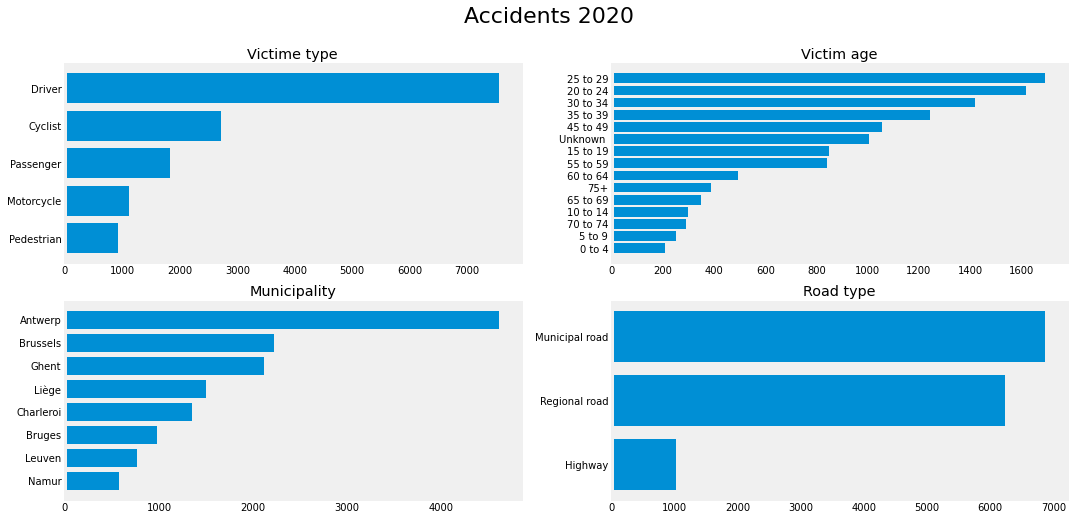

In [12]:
# background color #efefef
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 8))

to_plot = TF_ACCIDENTS_VICTIMS_2020.victimes_typesEN.value_counts(dropna=False, ascending=True)
ax[0][0].barh(np.arange(len(to_plot)),to_plot.values, tick_label=to_plot.index)
ax[0][0].set_title('Victime type')

to_plot = TF_ACCIDENTS_VICTIMS_2020.ages_EN.value_counts(dropna=True, ascending=True)
ax[0][1].barh(np.arange(len(to_plot)),to_plot.values, tick_label=to_plot.index)
ax[0][1].set_title('Victim age')

to_plot = TF_ACCIDENTS_VICTIMS_2020.places_EN.value_counts(dropna=False, ascending=True)
ax[1][0].barh(np.arange(len(to_plot)),to_plot.values, tick_label=to_plot.index)
ax[1][0].set_title('Municipality')

to_plot = TF_ACCIDENTS_VICTIMS_2020.road_typesEN.value_counts(dropna=False, ascending=True)
ax[1][1].barh(np.arange(len(to_plot)),to_plot.values, tick_label=to_plot.index)
ax[1][1].set_title('Road type')
fig.suptitle("Accidents 2020", fontsize=22)

In [13]:
TF_ACCIDENTS_VICTIMS_2020.MS_DEAD_30_DAYS.sum()

54

In [14]:
# filter by places only
placesNL = ['Brussel', 
            'Antwerpen', 
            'Leuven', 
            'Luik', 
            'Namen', 
            'Brugge', 
            'Charleroi', 
            'Gent']
            
TF_ACCIDENTS_2020 = TF_ACCIDENTS_2020[TF_ACCIDENTS_2020.TX_MUNTY_DESCR_NL.isin(placesNL)]

In [15]:
dead_2020 = TF_ACCIDENTS_VICTIMS_2020.value_counts(subset=['TX_MUNTY_DESCR_NL', 'MS_DEAD_30_DAYS'])
accidents_2020 = TF_ACCIDENTS_2020.TX_MUNTY_DESCR_NL.value_counts() 

accidents_2020

Antwerpen    1942
Brussel      1057
Gent          979
Luik          628
Charleroi     529
Brugge        440
Leuven        389
Namen         249
Name: TX_MUNTY_DESCR_NL, dtype: int64

In [16]:
# https://en.wikipedia.org/wiki/List_of_most_populous_municipalities_in_Belgium
# There are several sources for the population.

dead_list = [5, 15, 1, 5, 6, 3, 9, 10]
accidents_list = [1057, 1942 , 389 , 628, 249 , 440, 529, 979]
pop_list = [185103, 1529247, 102275, 197217, 111432, 118656, 202746, 263927]
accidents_per_1000 = [0] * len(pop_list)

for i in range(len(pop_list)):
    accidents_per_1000[i] = round(accidents_list[i] / (pop_list[i] / 1000), 2)

deaths_per_100000 = [0] * len(pop_list)
for i in range(len(pop_list)):
    deaths_per_100000[i] = round(dead_list[i] / (pop_list[i] / 100000), 2)

dict = {'Municipality':['Brussels','Antwerp','Leuven','Liège','Namur', 'Bruges', 'Charleroi', 'Ghent'],
        'Dead 30 days': dead_list,
        'Accidents': accidents_list,
        'Population': pop_list, 
        'Accidents per 1000 inhab': accidents_per_1000,
        'Deaths per 100000 inhab': deaths_per_100000, 
}

df = pd.DataFrame(dict)
df

,Municipality,Dead 30 days,Accidents,Population,Accidents per 1000 inhab,Deaths per 100000 inhab
0,Brussels,5,1057,185103,5.71,2.70
1,Antwerp,15,1942,1529247,1.27,0.98
2,Leuven,1,389,102275,3.80,0.98
3,Liège,5,628,197217,3.18,2.54
4,Namur,6,249,111432,2.23,5.38
5,Bruges,3,440,118656,3.71,2.53
6,Charleroi,9,529,202746,2.61,4.44
7,Ghent,10,979,263927,3.71,3.79


In [17]:
# Save processed data
# from google.colab import files
# df.to_csv('processed.csv') 
# files.download('processed.csv')

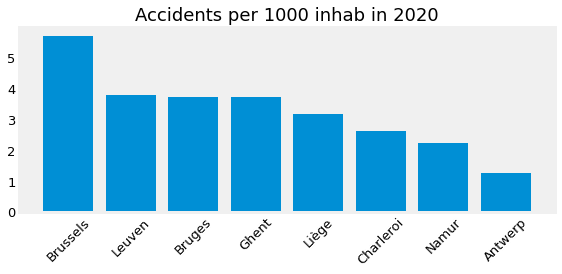

In [18]:
# graphs Accidents per 1000 inhab
to_plot = df.sort_values(by=['Accidents per 1000 inhab'], ascending=False)

plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
plt.rc('ytick', labelsize=13)    # fontsize of the tick labels
plt.rc('legend', fontsize=13)    # legend fontsize
plt.rc('font', size=13)    

plt.figure(figsize=(8,4), tight_layout=True)
plt.bar(to_plot['Municipality'], to_plot['Accidents per 1000 inhab'])
plt.title('Accidents per 1000 inhab in 2020')
plt.xticks(rotation=45)
plt.show()

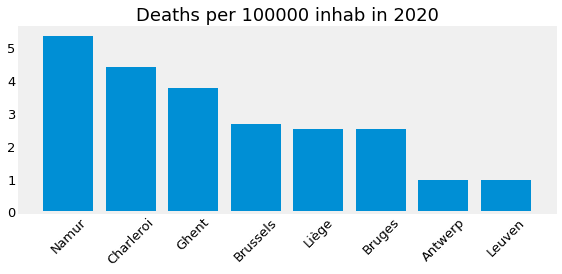

In [19]:
# graphs Deaths per 100000 inhab
to_plot = df.sort_values(by=['Deaths per 100000 inhab'], ascending=False)

plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
plt.rc('ytick', labelsize=13)    # fontsize of the tick labels
plt.rc('legend', fontsize=13)    # legend fontsize
plt.rc('font', size=13)    

plt.figure(figsize=(8,4), tight_layout=True)
plt.bar(to_plot['Municipality'], to_plot['Deaths per 100000 inhab'])
plt.title('Deaths per 100000 inhab in 2020')
plt.xticks(rotation=45)
plt.show()

In [20]:
AIR_POLLUTION.shape

(615, 12)

In [21]:
AIR_POLLUTION.columns

Index(['City', 'Location', 'Coordinates', 'Country Code', 'Pollutant',
       'Source Name', 'Unit', 'Value', 'Last Updated', 'Country', 'lat',
       'long'],
      dtype='object')

In [22]:
# Cleaning up unused columns
AIR_POLLUTION = AIR_POLLUTION.drop(['Coordinates', 'Country Code', 'Last Updated', 'Country'],axis=1)

In [23]:
AIR_POLLUTION.head()

,City,Location,Pollutant,Source Name,Unit,Value,lat,long
0,Flanders,Belgium - Flanders - 40AB02 - BERENDRECHT,PM10,EEA Belgium,µg/m³,39.2,51.34073,4.3218203
1,Brussels,Belgium - Brussels - 41R012 - UCCLE,SO2,EEA Belgium,µg/m³,2.0,50.79663,4.3585386
2,Flanders,Belgium - Flanders - 42N046 - GELLIK,NO2,EEA Belgium,µg/m³,5.0,50.882298,5.618874
3,Flanders,Belgium - Flanders - 42R897 - ANTWERPEN,SO2,EEA Belgium,µg/m³,0.0,51.250107,4.3421044
4,Wallonia,Belgium - Wallonia - 43H201 - LIEGE,SO2,EEA Belgium,µg/m³,0.5,50.624992,5.5474644


In [24]:
AIR_POLLUTION.Pollutant.unique()

array(['PM10', 'SO2', 'NO2', 'O3', 'CO', 'PM2.5'], dtype=object)

In [25]:
# filter by NO2 only
to_mantain = ['NO2']

to_plot = AIR_POLLUTION.copy()
to_plot.head()
          
to_plot = to_plot[to_plot.Pollutant.isin(to_mantain)]
to_plot.head()

,City,Location,Pollutant,Source Name,Unit,Value,lat,long
2,Flanders,Belgium - Flanders - 42N046 - GELLIK,NO2,EEA Belgium,µg/m³,5.0,50.882298,5.618874
8,Wallonia,Belgium - Wallonia - 45R502 - LODELINSART,NO2,EEA Belgium,µg/m³,26.0,50.428997,4.4586806
11,Vlaams-Brabant,Belgium - Vlaams-Brabant - BELSZ02,NO2,EEA Belgium,µg/m³,4.0,50.91302,4.512184
12,Brussels-Capital Region,Belgium - Brussels-Capital Region - BETB011,NO2,EEA Belgium,µg/m³,3.0,50.858032,4.2883363
26,Brussels,Belgium - Brussels - 41B011 - BERCHEM S.A,NO2,EEA Belgium,µg/m³,4.0,50.858032,4.2883363


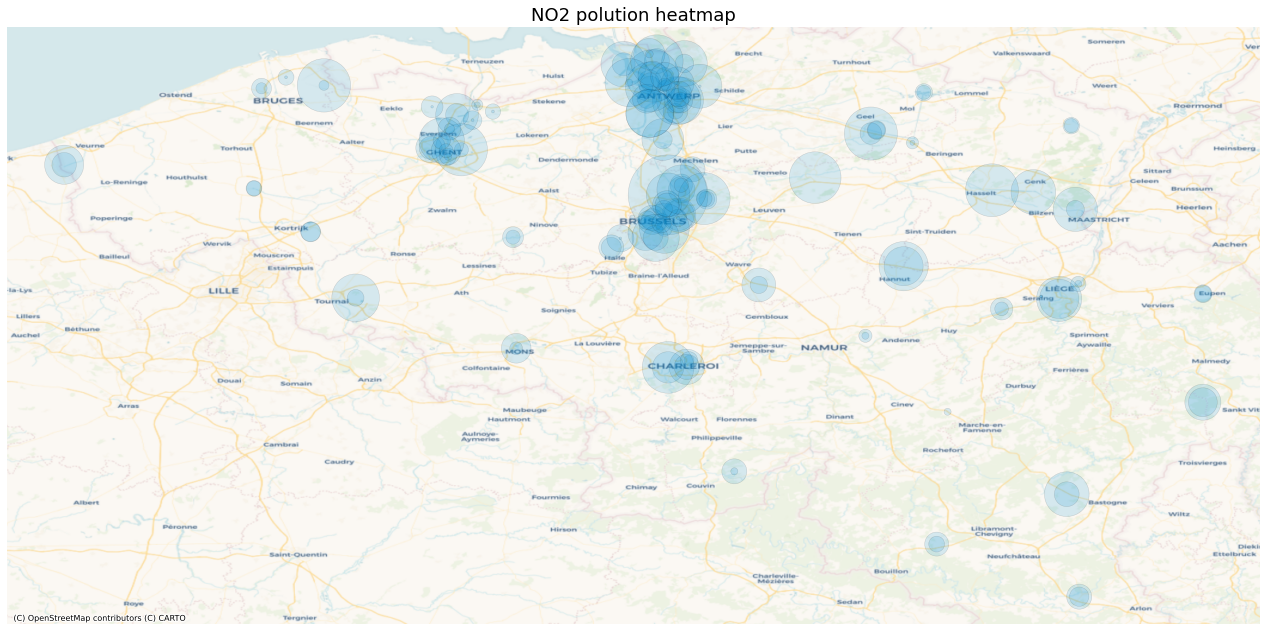

In [26]:
# Add Polution heat map

from shapely.geometry import Point

to_plot = to_plot.astype({'long':'float','lat':'float'})

polution_points = [Point(xy) for xy in zip (to_plot["long"], to_plot["lat"])]

polution = gpd.GeoDataFrame(to_plot.index, crs='epsg:4326', geometry=polution_points)
ax = polution.plot(figsize=(20, 20), alpha=0.15, edgecolor='black', legend=True,  markersize=AIR_POLLUTION['Value']*50)
cx.add_basemap(ax, crs='epsg:4326', source=cx.providers.CartoDB.Voyager)
# # cx.add_basemap(ax, crs='epsg:4326', source=cx.providers.OpenStreetMap.Mapnik)
ax.set_title('NO2 polution heatmap')
_ = ax.axis('off')

In [27]:
BRUSSEL_TRANSVERSALS_UBER.head()

,hexid,dayType,traversals,wktGeometry
0,8c1fa441bcecbff,weekday,498,POLYGON ((4.366729383607413 50.832931175001654...
1,8c1fa441bc507ff,weekday,457,"POLYGON ((4.366497542930552 50.83335761876832,..."
2,8c1fa441bc50dff,weekday,1208,"POLYGON ((4.366173462256108 50.83351572685339,..."
3,8c1fa441bc545ff,weekday,984,"POLYGON ((4.365849380816355 50.83367383334301,..."
4,8c1fa441bc725ff,weekday,803,"POLYGON ((4.365448015796987 50.83397408318209,..."


In [28]:
STATIONS.head()

,number,contract_name,name,address,position,banking,bonus,bike_stands,available_bike_stands,available_bikes,status,last_update,lat,lng
0,231,bruxelles,231 - KERSBEEK,KERSBEEK - AV KERSBEEK 107 / KERSBEEKLAAN 107,"{'lat': 50.805801, 'lng': 4.3194}",False,False,19,10,9,OPEN,1647714679000,50.805801,4.319400
1,122,bruxelles,122 - GARE D'ETTERBEEK,GARE D'ETTERBEEK/STATION VAN ETTERBEEK - BOULE...,"{'lat': 50.822207, 'lng': 4.389325}",False,True,30,26,4,OPEN,1647714898000,50.822207,4.389325
2,1,bruxelles,001 - LEOPOLD II,LEOPOLD II - AVENUE DE TERVUREN FACE / TERVURE...,"{'lat': 50.836304, 'lng': 4.41505}",False,True,20,19,1,OPEN,1647714976000,50.836304,4.415050
3,212,bruxelles,212 - THEO LAMBERT,THEO LAMBERT - BD THEO LAMBERT (FACE 60) / THE...,"{'lat': 50.827106, 'lng': 4.2925}",False,False,25,5,20,OPEN,1647714942000,50.827106,4.292500
4,333,bruxelles,333 - TRACTEBEL,TRACTEBEL - AV MARCEL THIRY FACE AU N°93,"{'lat': 50.856582, 'lng': 4.430988}",False,False,25,15,10,OPEN,1647714586000,50.856582,4.430988


In [29]:
from shapely import wkt

OSM_Brussels = pd.read_excel(osm_data, 'Brussels, Belgium')
OSM_Antwerp = pd.read_excel(osm_data, 'Antwerp, Belgium')
OSM_Leuven = pd.read_excel(osm_data, 'Leuven, Belgium')
OSM_Liege = pd.read_excel(osm_data, 'Liège,  Belgium')
OSM_Namur = pd.read_excel(osm_data, 'Namur, Belgium')
OSM_Bruges = pd.read_excel(osm_data, 'Bruges, Belgium')
OSM_Charleroi = pd.read_excel(osm_data, 'Charleroi, Belgium')
OSM_Ghent = pd.read_excel(osm_data, 'Ghent, Belgium')

OSM_Brussels['geometry'] = OSM_Brussels['geometry'].apply(wkt.loads)
OSM_Brussels = gpd.GeoDataFrame(OSM_Brussels, crs='epsg:4326')
OSM_Antwerp['geometry'] = OSM_Antwerp['geometry'].apply(wkt.loads)
OSM_Antwerp = gpd.GeoDataFrame(OSM_Antwerp, crs='epsg:4326')
OSM_Leuven['geometry'] = OSM_Leuven['geometry'].apply(wkt.loads)
OSM_Leuven = gpd.GeoDataFrame(OSM_Leuven, crs='epsg:4326')
OSM_Liege['geometry'] = OSM_Liege['geometry'].apply(wkt.loads)
OSM_Liege = gpd.GeoDataFrame(OSM_Liege, crs='epsg:4326')
OSM_Namur['geometry'] = OSM_Namur['geometry'].apply(wkt.loads)
OSM_Namur = gpd.GeoDataFrame(OSM_Namur, crs='epsg:4326')
OSM_Bruges['geometry'] = OSM_Bruges['geometry'].apply(wkt.loads)
OSM_Bruges = gpd.GeoDataFrame(OSM_Bruges, crs='epsg:4326')
OSM_Charleroi['geometry'] = OSM_Charleroi['geometry'].apply(wkt.loads)
OSM_Charleroi = gpd.GeoDataFrame(OSM_Charleroi, crs='epsg:4326')
OSM_Ghent['geometry'] = OSM_Ghent['geometry'].apply(wkt.loads)
OSM_Ghent = gpd.GeoDataFrame(OSM_Ghent, crs='epsg:4326')

In [30]:
OSM_Brussels

,osmid,oneway,name,highway,maxspeed,length,geometry,lanes,junction,tunnel,ref,access,service,bridge,width
0,8174673,True,Rue Léopold - Leopoldstraat,pedestrian,30,56.594,"LINESTRING (4.35533 50.85001, 4.35531 50.84998...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,33739373,False,Rue du Fossé aux Loups - Wolvengracht,tertiary,30,11.825,"LINESTRING (4.35533 50.85001, 4.35528 50.85003...",2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,33739362,True,Rue de l'Écuyer - Schildknaapsstraat,residential,30,20.423,"LINESTRING (4.35427 50.84900, 4.35437 50.84897...",2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,741239064,False,Boulevard Maurice Lemonnier - Maurice Lemonnie...,tertiary,30,34.508,"LINESTRING (4.34456 50.84344, 4.34463 50.84351...",2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,13252094,False,Rue de la Senne - Zennestraat,living_street,20,105.941,"LINESTRING (4.34047 50.84785, 4.34051 50.84791...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11725,1039387331,False,NaN,path,NaN,49.599,"LINESTRING (4.37509 50.81475, 4.37494 50.81477...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11726,1039387331,False,NaN,path,NaN,49.599,"LINESTRING (4.37448 50.81496, 4.37454 50.81490...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11727,924125259,False,NaN,pedestrian,NaN,4.462,"LINESTRING (4.35655 50.85168, 4.35659 50.85171)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11728,924125259,False,NaN,pedestrian,NaN,6.052,"LINESTRING (4.35655 50.85168, 4.35651 50.85163)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


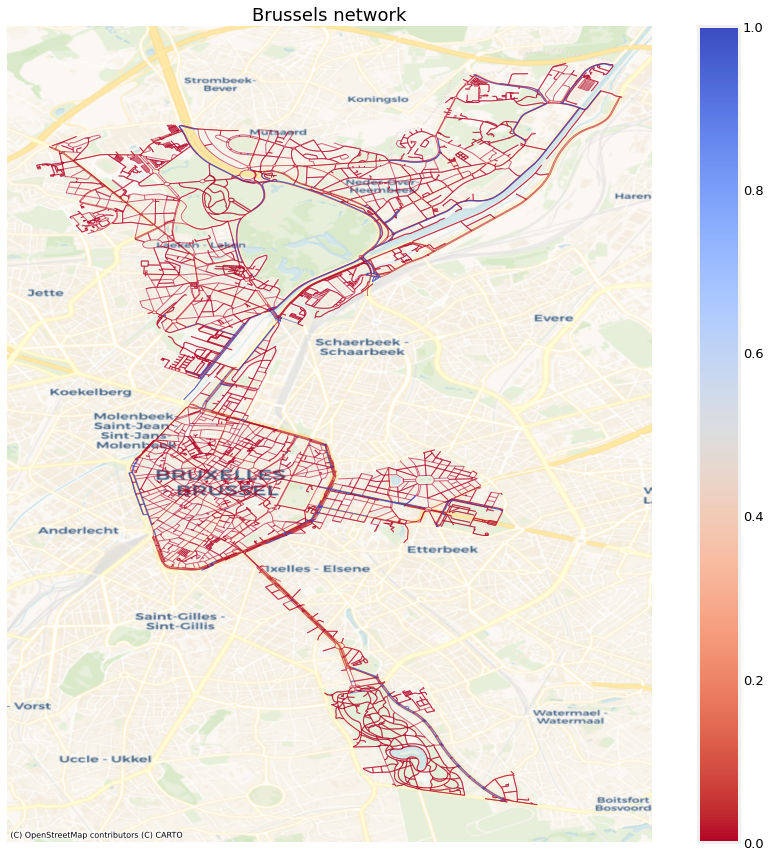

In [31]:
# Plot cycleways on brussels
ax = OSM_Brussels.plot(OSM_Brussels.highway == 'cycleway', 
                       cmap='coolwarm_r', 
                       figsize=(15 , 15), 
                       linewidth=1, 
                       alpha=0.6, 
                       edgecolor='black', 
                       legend=True)
cx.add_basemap(ax, crs='epsg:4326', 
               source=cx.providers.CartoDB.Voyager)
# cx.add_basemap(ax, crs='epsg:4326', source=cx.providers.OpenStreetMap.Mapnik)
ax.set_title('Brussels network')
_ = ax.axis('off')

In [32]:
OSM_Brussels.columns

Index(['osmid', 'oneway', 'name', 'highway', 'maxspeed', 'length', 'geometry',
       'lanes', 'junction', 'tunnel', 'ref', 'access', 'service', 'bridge',
       'width'],
      dtype='object')

In [33]:
STATIONS.columns

Index(['number', 'contract_name', 'name', 'address', 'position', 'banking',
       'bonus', 'bike_stands', 'available_bike_stands', 'available_bikes',
       'status', 'last_update', 'lat', 'lng'],
      dtype='object')

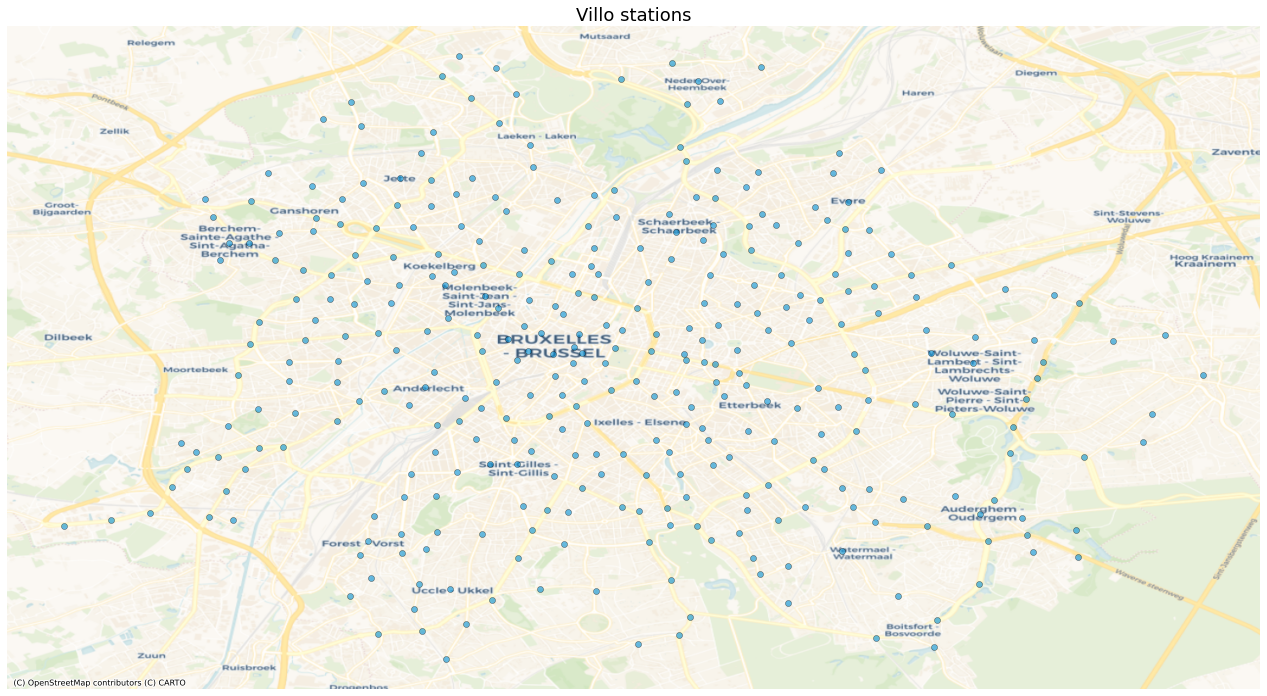

In [34]:
# Add stations

from shapely.geometry import Point

stations_points = [Point(xy) for xy in zip (STATIONS["lng"], STATIONS["lat"])]

stations = gpd.GeoDataFrame(STATIONS.index, crs='epsg:4326', geometry=stations_points)
ax = stations.plot(figsize=(20, 20), alpha=0.6, edgecolor='black', legend=True)
cx.add_basemap(ax, crs='epsg:4326', source=cx.providers.CartoDB.Voyager)
# cx.add_basemap(ax, crs='epsg:4326', source=cx.providers.OpenStreetMap.Mapnik)
ax.set_title('Villo stations')

_ = ax.axis('off')